# Matrix representation of quantum circuits: notations and conventions
> A case study by building a tensor network to match qiskit conventions

- toc: true 
- badges: true
- comments: true
- categories: [qiskit, tensor networks, quantum concepts]
- image: images/grovercirc.png

# Intro
Normally I use `qiskit` to experiment with quantum circuits. As any higher level environment it is very convenient for common tasks, but may turn out too inflexible for unusual use cases. A somewhat opposite approach is to use much lower level tools to gain in flexibility at the expense of convenience. I wanted to use Google's [`tensornetwork`](https://tensornetwork.readthedocs.io/en/latest/) package for simulations and training of quantum circuits, but this requires building many things that are for free in `qiskit` from scratch. It is also necessary to become explicit about conventions for matrix representation of quantum circuits. As long as you stay within a single framework this may not be an issue. I always anticipated though, that a day will come when I need to face my fears order all terms in a tensor product myself. Now it seems I'm past the difficult part and I'm better writing this down in case I would need to do something similar in the future.

OK, so what is the problem? Consider the following simple circuit built in `qiskit`:

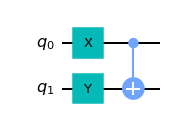

In [1]:
from qiskit import QuantumCircuit
from qiskit.quantum_info import Operator, Statevector

qc = QuantumCircuit(2)
qc.x(0)
qc.y(1)
qc.cx(0,1)
qc.draw(output='mpl')

It is not hard or ambiguous to interpret what this circuit does by inspecting the diagram. Say the input state is $q_0=|0\rangle$, $q_1=|1\rangle$. After $Y$ acts on $q_0$ it becomes $q_0\to X |0\rangle=|1\rangle$. Similarly, $q_1$ after $Y$ becomes $q_1\to Y|1\rangle=-i |0\rangle$. Since now $q_0$ is "on" the CNOT gate switches the state of $q_1$ further to $q_0 \to -i|1\rangle$. So the end result is that $q_0=|0\rangle, q_1=|1\rangle$ is transformed to $q_0=|0\rangle, q_1=-i|1\rangle$. Similarly we can work out what the circuit does for other computational basis states which by linearity fully fixes the action of the circuit. Although quite explicit, this is a clumsy description. This is why the matrix notation is usually used. And indeed, we can obtain the matrix corresponding to our quantum circuit quite easily in `qiskit`:

In [2]:
from qiskit.quantum_info import Operator, Statevector

U_qs = Operator(qc).data
U_qs

array([[0.+0.j, 0.+0.j, 0.+0.j, 0.-1.j],
       [0.+1.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+1.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.-1.j, 0.+0.j]])

It is important to realize that a number of conventions must be chosen before such explicit matrix representation can be written down. In the following I will clarify what are the conventions used in `qiskit` and reproduce the circuit with the `tensornetwork` library.

# Conventions for states

## Single qubit
First we need to give matrix representations to two basis states of a single qubit. Here I think it is quite uncontroversial to chose
\begin{align}
|0\rangle = \begin{pmatrix}1\\0\end{pmatrix},\qquad |1\rangle = \begin{pmatrix}0\\1\end{pmatrix} \label{kets}
\end{align}

These are the "ket" vectors. Their "bra" counterparts are
\begin{align}
\langle 0| = \begin{pmatrix}1 & 0\end{pmatrix}, \qquad \langle 1| = \begin{pmatrix}0 & 1\end{pmatrix} \label{bras}
\end{align}

With these, the following operators can be computed
\begin{align}
|0\rangle\langle 0| = \begin{pmatrix}1 & 0 \\ 0 & 0\end{pmatrix},\qquad |0\rangle\langle 1| = \begin{pmatrix}0 & 1 \\ 0 & 0\end{pmatrix},\qquad |1\rangle\langle 0| = \begin{pmatrix}0 & 0 \\ 1 & 0\end{pmatrix},\qquad |1\rangle\langle 1| = \begin{pmatrix}0 & 0 \\ 0 & 1\end{pmatrix} \label{ketbras}
\end{align}
## Multiple qubits
Where there is more than one qubit things become a bit more interesting and potentially confusing.The combined Hilbert space of two qubits $\mathcal{H}_2$ is a tensor product of single-qubit hilbert spaces $\mathcal{H}_2 = \mathcal{H}_1 \otimes \mathcal{H}_1$ but we need to decide which qubit goes first and which goes second. In `qiskit` a convention is adopted that additional qubits join from the *left*, i.e. when we have two qubits as here

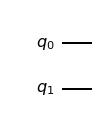

In [3]:
#collapse
qc01 = QuantumCircuit(2)
qc01.draw(output='mpl')


The state of the system is $|q_1\rangle\otimes |q_0\rangle$ (this is of course only true literally for [non-entangled states](https://idnm.github.io/blog/quantum%20concepts/qiskit/2021/07/12/Entanglement.html) ). OK, but how do we translate this into the matrix representation? The states in the tensor product of vector spaces can be represented by the [Kronecker product](https://en.wikipedia.org/wiki/Kronecker_product) which is not symmetric with respect to permutation arguments. Best way to explain how Kronecker product works is, as usual, through examples:

\begin{align}
\begin{pmatrix} 1 \\ 0 \end{pmatrix} \otimes \begin{pmatrix} a \\ b \end{pmatrix} = \begin{pmatrix} a \\ b \\ 0 \\ 0 \end{pmatrix},\qquad \begin{pmatrix} 0 \\ 1 \end{pmatrix} \otimes \begin{pmatrix} a \\ b \end{pmatrix} = \begin{pmatrix} 0\\ 0\\ a \\ b \end{pmatrix}
\end{align}
Result for generic left vector can be obtained by linearity
\begin{align}
\begin{pmatrix} x \\ y \end{pmatrix} \otimes \begin{pmatrix} a \\ b \end{pmatrix} = x \begin{pmatrix} 1 \\ 0 \end{pmatrix} \otimes \begin{pmatrix} a \\ b\end{pmatrix} +y\begin{pmatrix} 0 \\ 1 \end{pmatrix} \otimes \begin{pmatrix} a \\ b \end{pmatrix} = \begin{pmatrix} x a\\ x b\\ y a \\ y b \end{pmatrix}  = \begin{pmatrix} x \begin{pmatrix} a\\ b\end{pmatrix} \\ y  \begin{pmatrix} a \\  b\end{pmatrix} \end{pmatrix}
\end{align}

The last notation here is a bit informal but it shows what happens. One just substitutes the right vector into all elements of the left vector, multiplied by the corresponding components of the left vector. The Kronecker product is defined in the same way for matrices of arbitrary size, not just for two vectors.

So, now we can compute matrix representations of states in the computation basis of two-qubit system

\begin{align}
|00\rangle = \begin{pmatrix}1\\0 \end{pmatrix} \otimes \begin{pmatrix}1\\0 \end{pmatrix} = \begin{pmatrix}1\\0\\0\\0\end{pmatrix},\quad |01\rangle = \begin{pmatrix}1\\0 \end{pmatrix} \otimes \begin{pmatrix}0\\1 \end{pmatrix} = \begin{pmatrix}0\\1\\0\\0\end{pmatrix} \label{01}\\
|10\rangle = \begin{pmatrix}0\\1\end{pmatrix} \otimes \begin{pmatrix}1\\0 \end{pmatrix} = \begin{pmatrix}0\\0\\1\\0\end{pmatrix},\quad |11\rangle = \begin{pmatrix}0\\1\end{pmatrix} \otimes \begin{pmatrix}0\\1 \end{pmatrix} = \begin{pmatrix}0\\0\\0\\1\end{pmatrix}
\end{align}

There is a useful relation between the index of the non-zero element $n$ in the four-dimensional representation and the computational basis bitstring $q_1q_0$, namely $n=2q_1+q_0$. I.e. the bitstring $q_1q_0$ is the binary representation of the index $n$. This extends to arbitrary number of qubits, for example (try to obtain this from the tensor products!)
\begin{align}
|101\rangle = \begin{pmatrix}0\\0\\0\\0\\0\\1\\0\\0 \end{pmatrix} \label{101}
\end{align}

Don't believe me? Let's check that! In `qiskit` there is a convenient function to construct a vector representation from a bit string which we will take advantage of. First start with a two-qubit example:

In [4]:
s01 = Statevector.from_label('01')
s01.data

array([0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j])

 Comparing to \eqref{01} we find agreement. Similarly, 

In [5]:
s101 = Statevector.from_label('101')
s101.data

array([0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j])

Again, this is in agreement with \eqref{101}. Now with conventions for the ordering of tensor products set we can proceed to operators.

# Conventions for operators
One can say that convention for states representation and ordering of tensor products is a "vertical" convention. There is also a "horizontal" convention which might be potentially confusing. Consider the following circuit

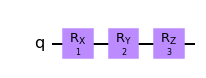

In [6]:
#collapse
qc123 = QuantumCircuit(1)
qc123.rx(1, 0)
qc123.ry(2, 0)
qc123.rz(3, 0)
qc123.draw(output='mpl')

Here, the operator $R_x$ is appplied first, the operator $R_y$ second and $R_z$ last. So in mathematical notation the circuit corresponds to $R_z R_y R_x$ and *not* to $R_x R_y R_z$. I think that the circuit notation is actually better. We think and write from left to right, this is also a direction that time flows on paper. When another thing happens, we write it to the right and it would be convenient to apply the corresponding operator to the right also. 


## What result do we expect?
With the set up in place we can compute the circuit of interest by hands. For convenience I plot it here once again:

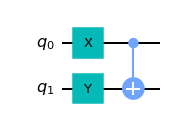

In [7]:
qc.draw(output='mpl')

OK, so what is the unitary matrix corresponding to this circuit. It is 
\begin{align}
U = CNOT_{01} \cdot (Y\otimes X)
\end{align}
Here
\begin{multline}
CNOT_{01} = \mathbb{1}\otimes |0\rangle\langle 0|+X\otimes |1\rangle\langle 1|=\\\begin{pmatrix}1&0\\0&1\end{pmatrix}\otimes \begin{pmatrix}1&0\\0&0\end{pmatrix}+\begin{pmatrix}0&1\\1&0\end{pmatrix}\otimes \begin{pmatrix}0&0\\0&1\end{pmatrix}=\begin{pmatrix}1&0&0&0\\0&0&0&1\\0&0&1&0\\0&1&0&0\end{pmatrix}
\end{multline}
and
\begin{align}
Y\otimes X = \begin{pmatrix} 0& -i\\i&0\end{pmatrix} \otimes \begin{pmatrix} 0& 1\\1&0\end{pmatrix}=\begin{pmatrix}0&0&0&-i\\0&0&-i&0\\0&i&0&0\\i&0&0&0\end{pmatrix}
\end{align}
Multiplying them together gives
\begin{align}
U = \begin{pmatrix}0 & 0 & 0 & -i \\ i&0&0&0 \\ 0 & i & 0 & 0 \\ 0 & 0 & -i & 0\end{pmatrix}
\end{align}
Alright, so this is indeed the matrix that `qiskit` computes:

In [9]:
U_qs

array([[0.+0.j, 0.+0.j, 0.+0.j, 0.-1.j],
       [0.+1.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+1.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.-1.j, 0.+0.j]])

## Now let us reproduce this with `tensornetworks`

First thing we will need are the matrices defining $X, Y$ and $CNOT$ gates. Let us introduce them.

In [11]:
import numpy as np

X = np.array([[0, 1], [1, 0]])
Y = np.array([[0, -1j], [1j, 0]])
CNOT = np.array([[1, 0, 0, 0],
                 [0, 0, 0, 1],
                 [0, 0, 1, 0],
                 [0, 1, 0, 0]])

Now, to actually construct a tensor network we must promote the matrices to `tensonework.node`'s. 

In [13]:
import tensornetwork as tn

x, y, cnot = list(map(tn.Node, [X, Y, CNOT.reshape(2,2,2,2)]))

Note that $CNOT$ is a $4\times4$ matrix, to represent in as a tensor with four legs we needed to reshape it appropriately. Reshaping is an important procedure which might be a bit tricky to ingest at first. Let me illustrate how it works on an example. Introduce two $4\times4$ matrices:

In [18]:
m1 = np.random.rand(4,4)
m2 = np.random.rand(4,4)